# Models from the R stemming process

**NB: GIULIO runned this script with the optimal parameters obtained in the hyperparameter tuning phase**

In [145]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [146]:
data = pd.read_csv('../../datasets/data-stemmed-R.csv')
Y = data['engagement.rate']
X = data.drop(columns=['engagement.rate'])
columns_to_scale= ['quotes','user.tweets','user.following','user.media'] 
scaler = StandardScaler()
X[columns_to_scale]= scaler.fit_transform(X[columns_to_scale]) 

In [147]:
def CVTest(model, str_model, X, Y, data, reg_metrics: pd.DataFrame, n_splits = 10, top_n_features = 25):
    kf = KFold(n_splits, shuffle=True,random_state=42)
    feature_names= data.drop(columns=['engagement.rate']).columns.tolist()   # Get list of feature names from the dataframe
    total_feature_importance = np.zeros(len(X.columns.tolist()))   # Initialize array to hold feature importances
    for train_index, test_index in kf.split(X):
        start_learn = time.time()
        model.fit(X.iloc[train_index], Y.iloc[train_index])
        end_learn = time.time()
        exe_time_learn = end_learn - start_learn

        # Feature importance calculation for applicable models
        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_
            total_feature_importance += feature_importance  # Accumulate feature importance for mean calculation
        else:
            print("This model does not provide feature importances.")
        
        start_pred = time.time()
        Y_pred = model.predict(X.iloc[test_index])
        end_pred = time.time()
        exe_time_pred = end_pred - start_pred

        current_mae = mean_absolute_error(Y.iloc[test_index], Y_pred)
        current_mse = mean_squared_error(Y.iloc[test_index], Y_pred)
        current_rmse = mean_squared_error(Y.iloc[test_index], Y_pred, squared=False)
        reg_metrics.loc[len(reg_metrics)] = [str_model.upper(), current_mae, current_mse, current_rmse, exe_time_learn, exe_time_pred]
    
    # Calculate mean importance over all folds
    mean_feature_importance = total_feature_importance / n_splits
    importance_df = pd.DataFrame({'Feature': feature_names, 'Mean Importance': mean_feature_importance})
    top_features = importance_df.nlargest(top_n_features, 'Mean Importance')
    print(f"Top {top_n_features} features based on mean importance over all folds:")
    print(top_features[['Feature', 'Mean Importance']])


In [148]:
reg_metrics_text = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'TIME_LEARN', 'TIME_PREDICT'])

This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood           

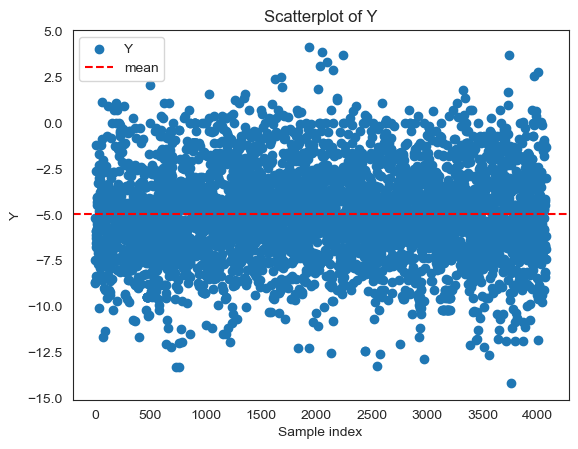

In [149]:
dummy = DummyRegressor()
CVTest(dummy, 'Dummy', X, Y, data, reg_metrics_text)

#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

In [150]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_regressor = DecisionTreeRegressor(min_samples_split=101)    # Try tuning on the hyperparameters: max_depth, min_samples_leaf, min_samples_split
CVTest(tree_regressor, 'Tree', X, Y, data, reg_metrics_text)

Top 25 features based on mean importance over all folds:
            Feature  Mean Importance
278     user.tweets         0.444261
279  user.following         0.205544
280      user.media         0.123704
268          quotes         0.107541
269      is.retweet         0.043518
277    user.website         0.014443
281      n_hashtags         0.011193
14              yum         0.004576
271        pictures         0.003314
272          videos         0.002570
3              food         0.001595
1          fastfood         0.001515
20         culinari         0.001370
55            avail         0.001307
28             time         0.001229
98             life         0.001226
0           chicken         0.001223
282         n_emoji         0.001178
117           veget         0.001114
211           thank         0.000974
154         countri         0.000830
186      agricultur         0.000776
78            india         0.000761
97              eat         0.000726
64             lin

In [151]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1,
                                     max_features=X.shape[1] // 3, min_samples_split=2, n_estimators=500)   # Try tuning on the hyperparameters: n_estimators, max_depth, min_samples_leaf, min_samples_split
CVTest(rf_regressor, 'RF', X, Y, data, reg_metrics_text)

Top 25 features based on mean importance over all folds:
                 Feature  Mean Importance
278          user.tweets         0.236201
279       user.following         0.197778
280           user.media         0.166345
268               quotes         0.070839
269           is.retweet         0.029451
281           n_hashtags         0.025359
277         user.website         0.023803
282              n_emoji         0.007947
274  multimedial_content         0.007316
3                   food         0.006291
276             user.bio         0.005871
271             pictures         0.005405
272               videos         0.003281
14                   yum         0.002961
194   httpssecondscomtip         0.002859
0                chicken         0.002541
255             icecream         0.002473
4                  foodi         0.002348
16                  face         0.002326
97                   eat         0.002310
26                 recip         0.002135
211                

In [152]:
svr_linear_regressor = SVR(kernel='linear',C=0.005) 
CVTest(svr_linear_regressor, 'SVR(lin)', X, Y, data, reg_metrics_text)

svr_poly_regressor = SVR(kernel='poly',C=0.1, degree=2) 
CVTest(svr_poly_regressor, 'SVR(poly)', X, Y, data, reg_metrics_text)

svr_rbf_regressor = SVR(kernel='rbf',C=5,gamma='scale') 
CVTest(svr_rbf_regressor, 'SVR(rbf)', X, Y, data, reg_metrics_text)

This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood           

In [153]:
knn_regressor = KNeighborsRegressor(n_neighbors=20)       #Try tuning on the hyperparameters: n_neighbors, weights
CVTest(knn_regressor, 'kNN', X, Y, data, reg_metrics_text)

This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood           

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
sns.boxplot(data=reg_metrics_text, x="Model", y="MAE", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="MSE", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="RMSE", ax=axs[0, 2], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_LEARN", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_PREDICT", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])

# Hide the empty subplot (if any)
axs[1, 2].axis('off')



plt.tight_layout()
plt.show()

print(X.columns[278])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.set_style('white')
# Boxplot for RMSE
custom_colors = ["#FFEC08", "#52BE80", "#F3564C", "#62CFFA", "#22D0E5", "#1A74C9", "#9B59B6"]

sns.boxplot(data=reg_metrics_text, x="Model", y="RMSE", ax=axs[0], palette=custom_colors)
axs[0].set_title('RMSE')
axs[0].set_xlabel('') 
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right') 
#add legend with type of technique
# Boxplot for TIME_LEARN
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_LEARN", ax=axs[1], palette=custom_colors)
axs[1].set_title('Learning Time')
#axs[1].set_ylim(0, 2)  # Set the y-axis limits to [0, 1]
# Boxplot for TIME_PREDICT
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_PREDICT", ax=axs[2], palette=custom_colors)
axs[2].set_title('Prediction Time')

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()
#fig.savefig('../../plots/techniques_comparison.png')

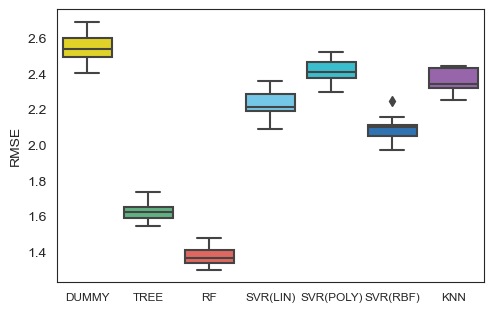

In [175]:
fig_width_cm = 14
fig_height_cm = 9

# Convert centimeters to inches (1 inch = 2.54 cm)
fig_width_inches = fig_width_cm / 2.54
fig_height_inches = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))


sns.set_style("white")
# Assuming reg_metrics_text is your DataFrame
custom_colors = ["#FFEC08", "#52BE80", "#F3564C", "#62CFFA", "#22D0E5", "#1A74C9", "#9B59B6"]

sns.boxplot(data=reg_metrics_text, x="Model", y="RMSE", palette=custom_colors)
plt.xticks(fontsize=8.5)
plt.xlabel('')
# Show the plot
plt.show()
#fig.savefig('../../plots/techniques_comparison_rmse.png')


In [ ]:
fig = plt.figure(figsize=(6.5, 5))


sns.set_style("white")
# Assuming reg_metrics_text is your DataFrame
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_LEARN", palette=sns.color_palette('Paired')[1::2])
plt.xticks(fontsize=9)
plt.xlabel('')
plt.ylabel('Learning Time (s)')
# Show the plot
plt.show()
fig.savefig('../../plots/techniques_comparison_time_learn.png')

In [ ]:
fig = plt.figure(figsize=(6.5, 5))
sns.set_style("white")
# Assuming reg_metrics_text is your DataFrame
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_PREDICT", palette=sns.color_palette('Paired')[1::2])
plt.xticks(fontsize=9)
plt.xlabel('')
plt.ylabel('Predicting Time (s)')
# Show the plot
plt.show()
fig.savefig('../../plots/techniques_comparison_time_predict.png')

# RELAXING RF PARAMETERS

In [ ]:
rf_regressor_1_250 = RandomForestRegressor(random_state=42, n_jobs=-1,
                                     max_features=X.shape[1] // 3, min_samples_split=2, n_estimators=250)   # Try tuning on the hyperparameters: n_estimators, max_depth, min_samples_leaf, min_samples_split
CVTest(rf_regressor_1_250, 'RF_1_250', X, Y, data, reg_metrics_text)

In [ ]:
rf_regressor_1_100 = RandomForestRegressor(random_state=42, n_jobs=-1,
                                     max_features=X.shape[1] // 3, min_samples_split=2, n_estimators=100)   # Try tuning on the hyperparameters: n_estimators, max_depth, min_samples_leaf, min_samples_split
CVTest(rf_regressor_1_100, 'RF_1_100', X, Y, data, reg_metrics_text)

In [ ]:
rf_regressor_20_100 = RandomForestRegressor(random_state=42, n_jobs=-1,
                                     max_features=X.shape[1] // 3, min_samples_split=21, n_estimators=100)   # Try tuning on the hyperparameters: n_estimators, max_depth, min_samples_leaf, min_samples_split
CVTest(rf_regressor_20_100, 'RF_20_100', X, Y, data, reg_metrics_text)

In [155]:
reg_metrics_text.groupby('Model').agg({'RMSE' : ['mean','std'],
                                       'TIME_LEARN' : ['mean','std'],
                                       'TIME_PREDICT' : ['mean','std']
                                       })

RMSE           TIME_LEARN           TIME_PREDICT          
               mean       std       mean       std         mean       std
Model                                                                    
DUMMY      2.549105  0.089576   0.001794  0.001395     0.000354  0.000173
KNN        2.360611  0.067055   0.004895  0.001546     0.011987  0.003710
RF         1.378885  0.054963   1.059897  0.029574     0.028119  0.000141
SVR(LIN)   2.226802  0.081544   1.527938  0.011513     0.156735  0.000537
SVR(POLY)  2.414326  0.077510   1.497768  0.008464     0.159862  0.001457
SVR(RBF)   2.092663  0.076907   1.651218  0.007761     0.274178  0.001831
TREE       1.631176  0.058566   0.026203  0.002916     0.001163  0.000200

In [ ]:
fig = plt.figure(figsize=(6.5, 5))
sns.set_style("white")
# Assuming reg_metrics_text is your DataFrame
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_PREDICT", palette=sns.color_palette('Paired')[1::2])
plt.xticks(fontsize=9)
plt.xlabel('')
plt.ylabel('Predicting Time (s)')
# Show the plot
plt.show()
#fig.savefig('../../plots/techniques_comparison_time_predict.png')